In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import r2_score

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
print(df_test.shape)

(10134, 11)
(10088, 11)


In [3]:
def visualize_prediction(y_test, y_pred):
    plt.figure(figsize=(12,8))
    plt.scatter(np.arange(len(y_test)),y_test,label = "Ground truth", s=3)
    plt.scatter(np.arange(len(y_test)),y_pred,label = "Prediction", s=3)
    plt.legend()
    plt.title("Ground truth vs OLS prediction")
    plt.xlabel("Index")
    plt.ylabel("Number of Crime")
    plt.show()
    
def evaluate_prediction(y_test,y_pred):
    print("R squared is:",r2_score(y_test, y_pred))
    print("MAE error is:",mean_absolute_error(y_test, y_pred))

# Data Cleaning

In [4]:
# Fill in missing values for median_home_value
print(df_train.isna().sum())
print(df_test.isna().sum())
fill_value =  df_train['median_home_value'].dropna().mean()
df_train['median_home_value'] = df_train['median_home_value'].fillna(fill_value)
df_test['median_home_value'] = df_train['median_home_value'].fillna(fill_value)
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

incident_day_of_week         0
incident_hour                0
zipcode                      0
police_district              0
crime                        0
population                   0
population_density           0
housing_units                0
occupied_housing_units       0
median_home_value          260
median_household_income      0
dtype: int64
incident_day_of_week         0
incident_hour                0
zipcode                      0
police_district              0
crime                        0
population                   0
population_density           0
housing_units                0
occupied_housing_units       0
median_home_value          234
median_household_income      0
dtype: int64
0
0


In [5]:
# Use one-hot encoding for categorical variable
X_train_raw = df_train.drop(columns = ['crime'])
X_test_raw = df_test.drop(columns = ['crime'])
X_train_dummy = pd.get_dummies(X_train_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode', 'police_district'], 
                               drop_first = True)
X_test_dummy = pd.get_dummies(X_test_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode', 'police_district'], 
                               drop_first = True)

In [6]:
# Standardize the numerical columns.
def standardize(df, cols, df_train):
    scalar = StandardScaler().fit(df_train[cols])
    result = df.copy()
    transformed_cols = scalar.transform(result[cols])
    result = result.drop(cols, 1)
    for i in range(len(cols)): 
        col = cols[i]
        result[col] = transformed_cols[:, i]
    return result
cols = ['population','population_density','housing_units',
        'occupied_housing_units','median_home_value','median_household_income']

X_test_clean = standardize(X_test_dummy,cols,X_train_dummy)
X_train_clean = standardize(X_train_dummy,cols,X_train_dummy)

In [7]:
X_train_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,police_district_Richmond,police_district_Southern,police_district_Taraval,police_district_Tenderloin,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,10134.000000,...,10134.000000,10134.000000,10134.000000,10134.000000,1.013400e+04,1.013400e+04,1.013400e+04,1.013400e+04,1.013400e+04,1.013400e+04
mean,0.143576,0.141899,0.138247,0.142787,0.142787,0.143971,0.035228,0.034636,0.033057,0.032564,...,0.055358,0.118216,0.085948,0.080324,5.100847e-17,3.856310e-18,-2.857175e-17,-3.049991e-17,3.908897e-16,-6.450556e-17
std,0.350677,0.348963,0.345177,0.349872,0.349872,0.351077,0.184365,0.182865,0.178794,0.177500,...,0.228689,0.322880,0.280302,0.271807,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.543427e+00,-1.575111e+00,-1.643352e+00,-1.645438e+00,-1.982466e+00,-1.620797e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.233798e-01,-7.240221e-01,-7.139354e-01,-7.650757e-01,-9.480662e-01,-8.257109e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.420276e-02,-1.998783e-01,-2.326126e-02,-4.047622e-02,-2.787027e-02,1.750194e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.246154e-01,5.048777e-01,4.279032e-01,4.581308e-01,9.126724e-01,5.602724e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.305784e+00,2.081511e+00,2.393879e+00,2.285408e+00,1.493544e+00,2.665813e+00


In [8]:
X_test_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,police_district_Richmond,police_district_Southern,police_district_Taraval,police_district_Tenderloin,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,...,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000
mean,0.143537,0.140464,0.139671,0.142645,0.143438,0.142546,0.036677,0.034695,0.034596,0.032216,...,0.057296,0.117764,0.087530,0.078906,0.005986,0.006317,0.012516,0.012385,-0.001030,0.001051
std,0.350637,0.347485,0.346662,0.349728,0.350536,0.349626,0.187977,0.183014,0.182762,0.176583,...,0.232418,0.322344,0.282624,0.269605,0.989009,0.996034,0.993706,0.993378,1.000133,0.995936
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.543427,-1.575111,-1.643352,-1.645438,-1.982466,-1.620797
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.623380,-0.724022,-0.713935,-0.765076,-0.948066,-0.825711
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.044203,-0.199878,-0.023261,-0.040476,-0.027870,0.175019
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.424615,0.504878,0.427903,0.458131,0.912672,0.560272
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.305784,2.081511,2.393879,2.285408,1.493544,2.665813


In [9]:
# Get y_train and y_test
y_train = df_train['crime'].values
y_test = df_test['crime'].values

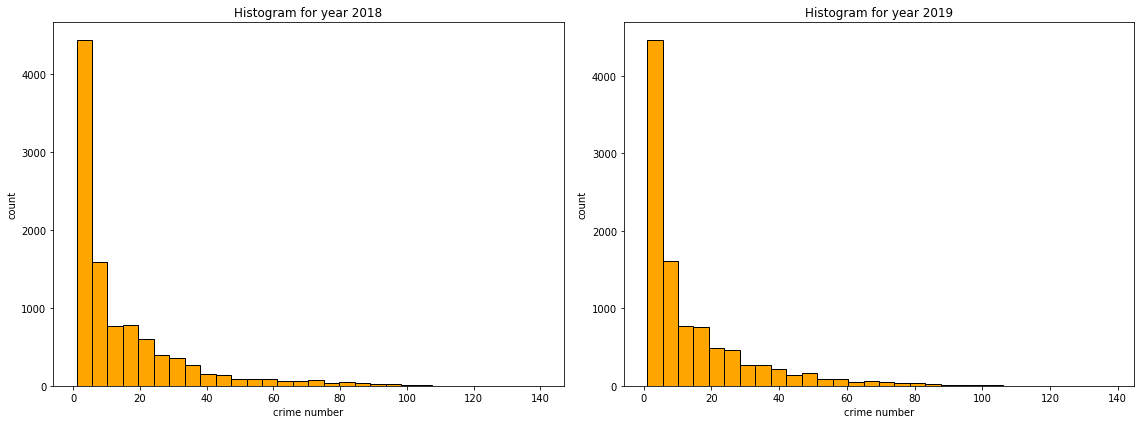

In [10]:
# Visualize crime distribution of 2018 and 2019
fig,ax = plt.subplots(1, 2, figsize=(16,6))

# Draw the plot
ax[0].hist(y_train,color = 'orange', edgecolor = 'black', bins=30)
# Title and labels
ax[0].set_title("Histogram for year 2018")
ax[0].set_xlabel('crime number')
ax[0].set_ylabel('count')
ax[1].hist(y_test,color = 'orange', edgecolor = 'black', bins=30)

# Title and labels
ax[1].set_title('Histogram for year 2019')
ax[1].set_xlabel('crime number')
ax[1].set_ylabel('count')

plt.tight_layout()
plt.show()

## Base Model

In [11]:
zipcode_avg_crime = df_train.groupby('zipcode')['crime'].mean().to_dict()
base_preds = df_test['zipcode'].map(zipcode_avg_crime).values
evaluate_prediction(y_test,base_preds)

R squared is: 0.12213459815253758
MAE error is: 11.6273478531969


## Linear Regression

In [12]:
# Check colinearity
X_numerical = X_train_clean[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
vif["features"] = X_numerical.columns
vif.round(1)

,VIF Factor,features
0,22.5,population
1,2.8,population_density
2,2000.1,housing_units
3,2295.3,occupied_housing_units
4,2.0,median_home_value
5,1.6,median_household_income


In [13]:
# Dropout columns with huge VIF Factor
X_train_final = X_train_clean.drop(columns=['population','housing_units','occupied_housing_units'])
X_test_final = X_test_clean.drop(columns=['population','housing_units','occupied_housing_units'])

In [14]:
import statsmodels.api as sm
linear_regression = sm.OLS(y_train, X_train_final)
results = linear_regression.fit()
y_pred_lr = results.predict(X_test_final)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     62.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:24:05   Log-Likelihood:                -42065.
No. Observations:               10134   AIC:                         8.426e+04
Df Residuals:                   10070   BIC:                         8.472e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
incident_day_of_week_Monday       -0.4761      0.569     -0.837      0.402      -1.591       0.638
incident_day_of_week_Saturday     -0.3831      0.571     -0.671      0.502      -1.501       0.735
incident_day_of_week_Sunday       -1.2964      0.574     -2.258      0.024      -2.422      -0.171
incident_day_of_week_Thursday     -0.9950      0.569     -1.747      0.081      -2.111       0.121
incident_day_of_week_Tuesday      -0.9784      0.569     -1.718      0.086      -2.095       0.138
incident_day_of_week_Wednesday    -0.4592      0.568     -0.808      0.419      -1.573       0.655
incident_hour_1                   -6.7417      1.083     -6.222      0.000      -8.866      -4.618
incident_hour_2                   -8.3863      1.089     -7.702      0.000     -10.521      -6.252
incident_hour_3                  -10.4255      1.104     -9.442      0.000     -12.590      -8.261
incident_hour_4                  -11.9801      1.108    -10.808      0.000     -14.153      -9.807
incident_hour_5                  -12.3453      1.111    -11.113      0.000     -14.523     -10.168
incident_hour_6                  -10.2697      1.082     -9.489      0.000     -12.391      -8.148
incident_hour_7                   -7.3782      1.061     -6.956      0.000      -9.457      -5.299
incident_hour_8                   -4.2363      1.028     -4.121      0.000      -6.251      -2.221
incident_hour_9                   -4.0324      1.010     -3.991      0.000      -6.013      -2.052
incident_hour_10                  -1.4515      1.016     -1.429      0.153      -3.443       0.540
incident_hour_11                  -0.7918      1.012     -0.782      0.434      -2.776       1.193
incident_hour_12                   3.3464      0.999      3.349      0.001       1.388       5.305
incident_hour_13                   0.1202      1.011      0.119      0.905      -1.861       2.101
incident_hour_14                  -0.4690      1.009     -0.465      0.642      -2.448       1.510
incident_hour_15                   0.9938      1.013      0.981      0.327      -0.992       2.980
incident_hour_16                   1.7285      1.008      1.715      0.086      -0.247       3.704
incident_hour_17                   2.5457      1.008      2.525      0.012       0.569       4.522
incident_hour_18                   3.2440      1.012      3.207      0.001       1.261       5.227
incident_hour_19                   2.7726      1.019      2.721      0.007       0.775       4.770
incident_hour_20                   0.8635      1.019      0.847      0.397      -1.135       2.862
incident_hour_21                  -1.3722      1.021     -1.344      0.179      -3.373       0.629
incident_hour_22                  -1.7763      1.034     -1.717      0.086      -3.804       0.251
incident_hour_

R squared is: 0.13501468226925906
MAE error is: 11.851080804348904


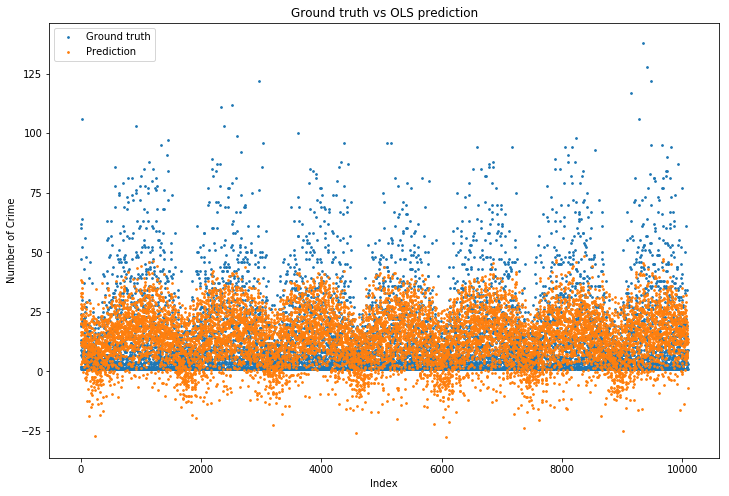

In [15]:
# Evaluate model performance
evaluate_prediction(y_test, y_pred_lr)
visualize_prediction(y_test, y_pred_lr)

## Regularization


### LASSO Regression

The best alpha for lasso is 0.01
R squared is: 0.2633188249966414
MAE error is: 10.525524060879214


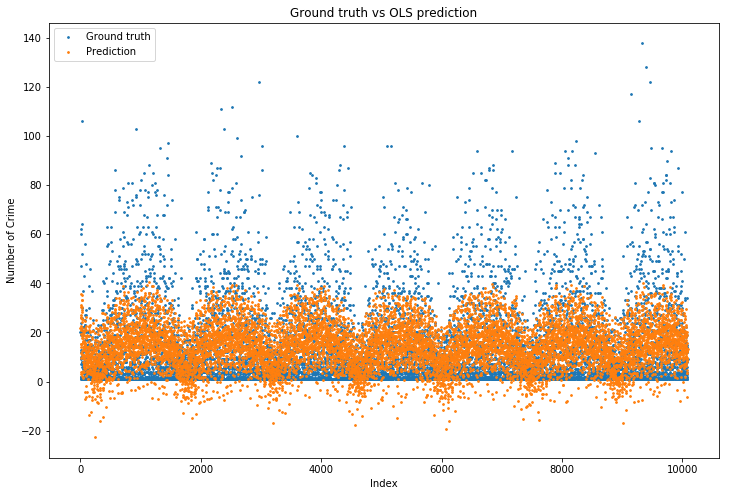

In [16]:
lam = [0.001,0.01,0.1,1,10]

# Fit the CV LASSO model
model_lasso = LassoCV(alphas = lam, max_iter = 100000, fit_intercept = True, cv = 5)
model_lasso.fit(X_train_final,y_train)
print("The best alpha for lasso is %s" %model_lasso.alpha_)
y_pred_lasso = model_lasso.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_lasso)
visualize_prediction(y_test, y_pred_lasso)

### Ridge Regression

The best alpha for ridge is 1.0
R squared is: 0.26547122088075537
MAE error is: 10.522509234829


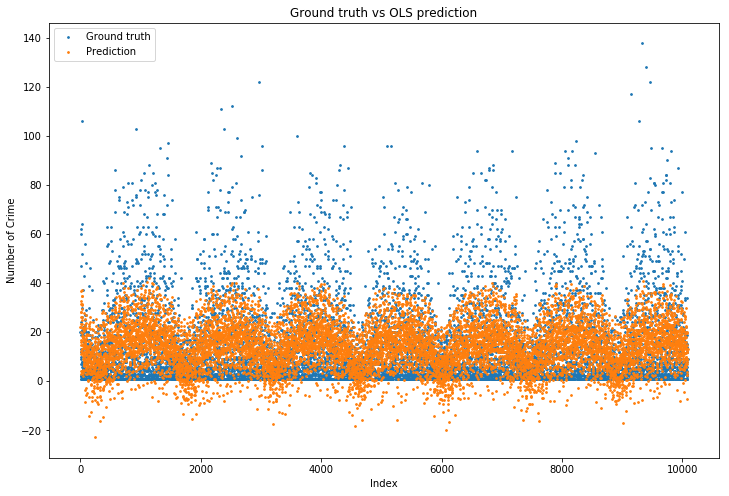

In [17]:
# Fit the Ridge model
model_ridge = RidgeCV(alphas = lam,fit_intercept = True,cv = 5)
model_ridge.fit(X_train_final,y_train)
print("The best alpha for ridge is %s" %model_ridge.alpha_)
y_pred_ridge = model_ridge.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_ridge)
visualize_prediction(y_test, y_pred_ridge)

## Random Forest

R squared is: 0.7952210689207864
MAE error is: 4.764938144329896


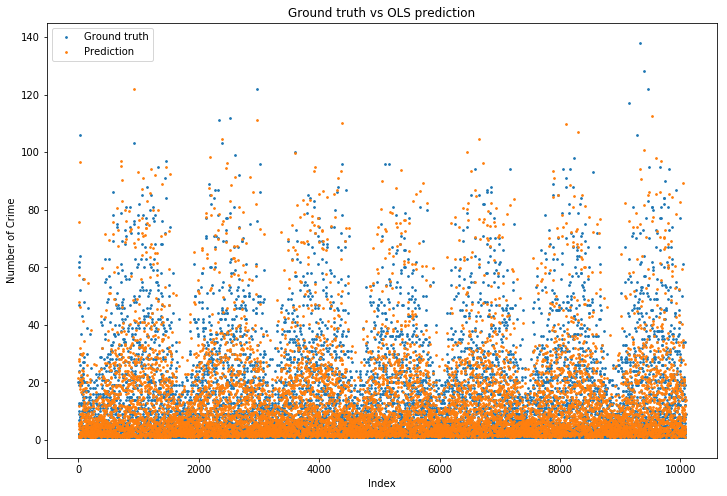

In [18]:
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(X_train_clean,y_train)
y_pred_rf = rf.predict(X_test_clean)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_rf)
visualize_prediction(y_test, y_pred_rf)

In [19]:
list(zip(X_train_final.columns, rf.feature_importances_))[:10]

[('incident_day_of_week_Monday', 0.007172057652495135),
 ('incident_day_of_week_Saturday', 0.010121188992594685),
 ('incident_day_of_week_Sunday', 0.012065099977099312),
 ('incident_day_of_week_Thursday', 0.007594008735587929),
 ('incident_day_of_week_Tuesday', 0.007607979125149183),
 ('incident_day_of_week_Wednesday', 0.008003811151986312),
 ('incident_hour_1', 0.014012090547153043),
 ('incident_hour_2', 0.01719261526026153),
 ('incident_hour_3', 0.02273742167479932),
 ('incident_hour_4', 0.025325086661836936)]

## KNN

R squared is: 0.48355852313902137
MAE error is: 8.127597145122918


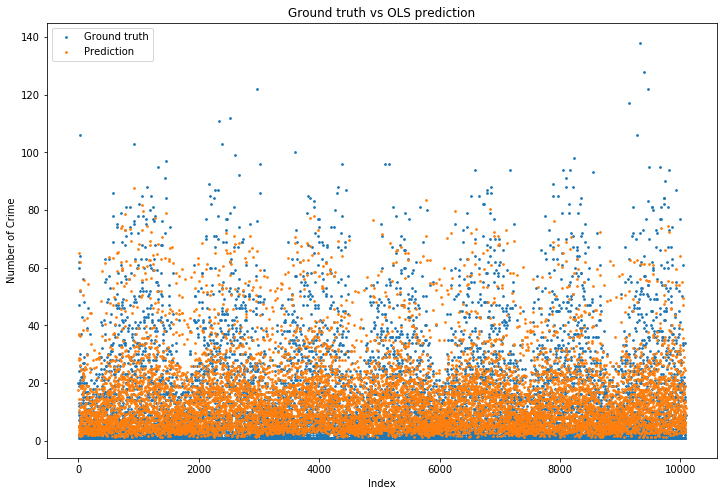

In [20]:
KNN = KNeighborsRegressor(n_neighbors=10)
KNN.fit(X_train_final,y_train)
y_pred_KNN = KNN.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_KNN)
visualize_prediction(y_test, y_pred_KNN)

## Neural Network

In [21]:
from tensorflow.keras import layers

validation_split = 0.2
epochs = 50
optimizer = tf.keras.optimizers.RMSprop(1e-3)
model = tf.keras.models.Sequential()
model.add(layers.Dense(units=100, activation='relu', input_dim = X_train_final.shape[1]))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=1, activation='relu'))
model.compile(loss = 'mae', optimizer = optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6700      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 16,901
Trainable params: 16,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_final, y_train, batch_size=64, epochs=epochs, 
                    validation_split=validation_split, verbose=1,
                    callbacks=[early_stop])

Train on 8107 samples, validate on 2027 samples
Epoch 1/50
8107/8107 [==============================] - 1s 64us/sample - loss: 11.1973 - val_loss: 11.4497
Epoch 2/50
8107/8107 [==============================] - 0s 40us/sample - loss: 10.0745 - val_loss: 10.5890
Epoch 3/50
8107/8107 [==============================] - 0s 40us/sample - loss: 9.3860 - val_loss: 9.9000
Epoch 4/50
8107/8107 [==============================] - 0s 46us/sample - loss: 8.7385 - val_loss: 9.3578
Epoch 5/50
8107/8107 [==============================] - 0s 51us/sample - loss: 8.2703 - val_loss: 8.8070
Epoch 6/50
8107/8107 [==============================] - 0s 36us/sample - loss: 7.7180 - val_loss: 8.3568
Epoch 7/50
8107/8107 [==============================] - 0s 49us/sample - loss: 7.3739 - val_loss: 7.9505
Epoch 8/50
8107/8107 [==============================] - 0s 49us/sample - loss: 6.9775 - val_loss: 7.6405
Epoch 9/50
8107/8107 [==============================] - 0s 36us/sample - loss: 6.7008 - val_loss: 7.4437
Epo

R squared is: 0.61167023302937
MAE error is: 6.281137828065953


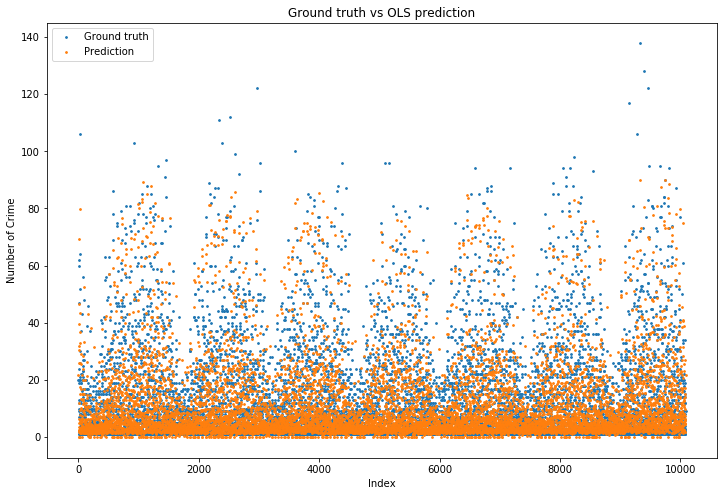

In [23]:
y_pred_NN = model.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_NN)
visualize_prediction(y_test, y_pred_NN)